文章名称: [I compared 6 methods to identify the trend of the stock market. These are the results! ](https://medium.com/python-in-plain-english/i-compared-6-methods-to-identify-the-trend-of-the-stock-market-edb1e70371ef)

文章名称:比较6种股市趋势识别方法

识别趋势在交易中至关重要，因为它可以帮助交易者与市场势头保持一致，实现利润最大化和风险最小化。
通过识别市场方向，交易者可以就进入和退出点做出明智的决策，改进整体策略并避免在波动条件下出现代价高昂的错误。

在本文中，您可以期待以下内容：
- 描述最常用的技术分析方法，使用指标来识别趋势;
- 对于每种方法，使用趋势作为信号，并计算收益率；
- 比较不同方法的各种统计数据；
- 使用上述知识获取一定数量的股票并呈现结果；

我们将导入整个代码中所需的库，并下载带有 SPY 价格的主 DataFrame。我使用 SPY，因为对我来说，在分析个股之前最重要的趋势识别是了解市场。

在原文基础上为更好理解，做以下调整：
- 作者使用SPY作为标的，考虑更加贴近自身环境，便于理解和对比，标的该为ETF 516510.SH。
- 向上趋势：green 改为 red；向下趋势：red 改为 green

In [ ]:
# Import necessary libraries
#import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np

import sys
# 尝试导入 watermark 库
try:
    import watermark
    print("watermark library is already installed.")
except ImportError:
    print("watermark library is not installed. Installing now...")
    # 使用 ! 来运行 shell 命令安装 watermark 库
    !{sys.executable} -m pip install watermark
    # 再次尝试导入 watermark 库
    import watermark
    print("watermark library has been installed.")

## 运行环境

In [ ]:
%load_ext watermark
%watermark -a "lleasy" -d -v -m -p numpy,pandas,matplotlib,pandas_ta

In [ ]:
# Download the stock data
ticker = '516510.SH' 
#df = yf.download(ticker, start='2023-01-01', end='2024-06-01')
df = pd.read_csv('./516510.SH.csv',parse_dates=['datetime'])
df = df[['ts_code','datetime','open','high','low','close','vol']]
df = df.set_index('datetime')
df = df.query('datetime<=20230101').copy()
df.head(2)

In [ ]:
def calculate_returns(df_for_returns, col_for_returns = 'close', col_for_signal = 'Trend'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Daily_Returns'] = df[col_for_returns].pct_change()
    df_for_returns['Returns'] = df_for_returns['Daily_Returns'] * df_for_returns[col_for_signal].shift(1)
    df_for_returns['Returns'] = df_for_returns['Returns'].fillna(0)
    # 股票或投资组合的权益曲线（Equity Curve）是投资领域中用来展示投资组合价值随时间变化的图表，通常用来评估投资策略的表现。
    df_for_returns['Equity Curve'] = 100 * (1 + df_for_returns['Returns']).cumprod()

    equity_curve = df_for_returns['Equity Curve']
    # Calculate the running maximum of the equity curve
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max) / cumulative_max
    stats['max_drawdown'] = drawdown.min()

    # calculate the sharpe ratio
    stats['sharpe_ratio'] = (df_for_returns['Returns'].mean() / df_for_returns['Returns'].std()) * np.sqrt(252)

    # calculate the total return
    stats['total_return'] = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1

    # calculate the number of long signals
    stats['number_of_long_signals'] = len(df_for_returns[df_for_returns[col_for_signal] == 1])

    # calculate the number of short signals
    stats['number_of_short_signals'] = len(df_for_returns[df_for_returns[col_for_signal] == -1])

    return df_for_returns['Equity Curve'], stats

## 快速(9) + 慢速(21) 移动平均线MA

这种方法是最基本的趋势方法，也是最简单的。您有 2 个移动平均线。当快速值高于慢值时，表明呈上升趋势。


In [ ]:
def calculate_trend_2_ma(df_ohlc, period_slow=21, period_fast=9):
    # Calculate Moving Averages (fast and slow) using pandas_ta
    df_ohlc['MA_Fast'] = df_ohlc.ta.sma(close='Close', length=period_fast)
    df_ohlc['MA_Slow'] = df_ohlc.ta.sma(close='Close', length=period_slow)

    # Determine the trend based on Moving Averages
    def identify_trend(row):
        if row['MA_Fast'] > row['MA_Slow']:
            return 1
        elif row['MA_Fast'] < row['MA_Slow']:
            return -1
        else:
            return 0
        
    df_ohlc = df_ohlc.assign(Trend=df_ohlc.apply(identify_trend, axis=1))
    df_ohlc['Trend'] =  df_ohlc['Trend'].fillna('0')

    return df_ohlc['Trend']

df['Trend'] = calculate_trend_2_ma(df, period_slow=21, period_fast=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7), sharex=True)

# Plotting the close price with the color corresponding to the trend
# 当快速值高于慢值时，表明呈上升趋势。
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            #, color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , color='green' if df['Trend'].iloc[i] == 1 else ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_Fast'], label='9-day MA (Fast)', color='blue')
ax1.plot(df['MA_Slow'], label='21-day MA (Slow)', color='orange')
ax1.set_title(f'{ticker} - Price and Moving Averages')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.legend(loc='best')

plt.show()

## 移动平均线MA + MACD

这两个指标应该保持一致。这意味着要识别上升趋势，收盘价应高于移动平均线，MACD 线应高于 MACD 信号。


In [ ]:
def calculate_trend_macd_ma(df_ohlc, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9):
    # Calculate MACD using pandas_ta
    df_ohlc.ta.macd(close='close', fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)

    # Calculate Moving Average
    df_ohlc['MA'] = df_ohlc.ta.sma(close='close', length=ma_period)

    # Determine the trend based on MA and MACD
    def identify_trend(row):
        macd_name = f'{macd_fast}_{macd_slow}_{macd_signal}'
        # 收盘价应高于移动平均线，MACD 线应高于 MACD 信号。
        if row['close'] > row['MA'] and row[f'MACD_{macd_name}'] > row[f'MACDs_{macd_name}']:
            return 1
        elif row['close'] < row['MA'] and row[f'MACD_{macd_name}'] < row[f'MACDs_{macd_name}']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            , color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot the Moving Average
ax1.plot(df['MA'], label=f'50-day MA', color='orange')
ax1.set_title(f'{ticker} - Price and Moving Average')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.legend(loc='best')

# Plot MACD and Signal Line on the second subplot (smaller height)
ax2.plot(df.index, df['MACD_12_26_9'], label='MACD', color='blue')
ax2.plot(df.index, df['MACDs_12_26_9'], label='Signal Line', color='red')
ax2.set_title(f'{ticker} - MACD')
ax2.legend(loc='best')

plt.show()


## RSI + 快速和慢速移动平均线

与上述类似，我们将使用快速和慢速移动平均线，但与 RSI 一起使用。假设是两个信号都应该再次保持一致。快速 MA 应高于慢速 MA，RSI > 50 以确定上升趋势和下降趋势的相反趋势。


In [ ]:
def calculate_trend_rsi_ma(df_ohlc, rsi_period=14, ma_fast=9, ma_slow=21):

    # Calculate RSI using pandas_ta
    df_ohlc['RSI'] = df.ta.rsi(close='close', length=rsi_period)

    # Calculate Moving Averages (14-day and 50-day) using pandas_ta
    df_ohlc[f'MA_{ma_fast}'] = df_ohlc.ta.sma(close='close', length=14)
    df_ohlc[f'MA_{ma_slow}'] = df_ohlc.ta.sma(close='close', length=50)

    # Determine the trend based on RSI and Moving Averages
    # 快速 MA 应高于慢速 MA，RSI > 50 以确定上升趋势
    def identify_trend(row):
        if row['RSI'] > 50 and row[f'MA_{ma_fast}'] > row[f'MA_{ma_slow}']:
            return 1
        elif row['RSI'] < 50 and row[f'MA_{ma_fast}'] < row[f'MA_{ma_slow}']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=14, ma_slow=50)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            , color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_14'], label='14-day MA', color='blue')
ax1.plot(df['MA_50'], label='50-day MA', color='orange')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, RSI and Fast and Slow Moving Average')
ax1.legend(loc='best')

# Plot RSI on the second subplot (smaller height)
ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
ax2.axhline(50, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at RSI=50
ax2.set_title(f'{ticker} - RSI')
ax2.legend(loc='best')

plt.show()

## 布林带 + RSI

现在让我们尝试将布林带与 RSI 相结合。同样，这两个信号需要保持一致。当价格高于中间布林带且 RSI 高于 50 时，我们有一个上升趋势。


In [ ]:
def calculate_trend_bbands_rsi(df_ohlc, bbands_period=5, bbands_std=2, rsi_period=14):

    # Calculate RSI using pandas_ta
    df_ohlc['RSI'] = df_ohlc.ta.rsi(close='close', length=rsi_period)

    # Calculate Bollinger Bands using pandas_ta
    bbands = df.ta.bbands(close='close', length=bbands_period, std=bbands_std)
    df_ohlc['BB_upper'] = bbands[f'BBU_{bbands_period}_{bbands_std}.0']
    df_ohlc['BB_middle'] = bbands[f'BBM_{bbands_period}_{bbands_std}.0']
    df_ohlc['BB_lower'] = bbands[f'BBL_{bbands_period}_{bbands_std}.0']

    # Determine the trend based on Bollinger Bands and RSI
    # 当价格高于中间布林带且 RSI 高于 50 时，上升趋势。
    def identify_trend(row):
        if row['close'] > row['BB_middle'] and row['RSI'] > 50:
            return 1
        elif row['close'] < row['BB_middle'] and row['RSI'] < 50:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_bbands_rsi(df, bbands_period=20, bbands_std=2, rsi_period=14)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            , color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot Bollinger Bands
ax1.plot(df['BB_upper'], label='Upper Band', color='blue', linestyle='--')
ax1.plot(df['BB_middle'], label='Middle Band', color='orange')
ax1.plot(df['BB_lower'], label='Lower Band', color='blue', linestyle='--')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, RSI and Bollinger Bands')
ax1.legend(loc='best')

# Plot RSI on the second subplot (smaller height)
ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
ax2.axhline(50, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at RSI=50
ax2.set_title(f'{ticker} - RSI')
ax2.legend(loc='best')

plt.show()

## 慢速和快速移动平均线 + ADX

通过结合 ADX 和移动平均线，当 ADX 高于 25（表明强劲趋势）且快速 MA 高于慢速 MA 时，我们将确定上升趋势。


In [ ]:
def calculate_trend_adx_ma(df_ohlc, adx_period=14, fast_ma_period=14, slow_ma_period=50):
    # Calculate ADX using pandas_ta
    df_ohlc['ADX'] = df_ohlc.ta.adx(length=adx_period)[f'ADX_{adx_period}']

    # Calculate Moving Averages (14-day and 50-day) using pandas_ta
    df_ohlc['MA_fast'] = df_ohlc.ta.sma(close='close', length=fast_ma_period)
    df_ohlc['MA_slow'] = df_ohlc.ta.sma(close='close', length=slow_ma_period)

    # Determine the trend based on ADX and Moving Averages
    # 当 ADX 高于 25（表明强劲趋势）且快速 MA 高于慢速 MA 时，上升趋势
    def identify_trend(row):
        if row['ADX'] > 25 and row['MA_fast'] > row['MA_slow']:
            return 1
        elif row['ADX'] > 25 and row['MA_fast'] < row['MA_slow']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            , color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_fast'], label='Fast MA', color='blue')
ax1.plot(df['MA_slow'], label='Slow MA', color='orange')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, ADX and Moving Averages')
ax1.legend(loc='best')

# Plot ADX on the second subplot (smaller height)
ax2.plot(df.index, df['ADX'], label='ADX', color='purple')
ax2.axhline(25, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at ADX=25
ax2.set_title(f'{ticker} - ADX')
ax2.legend(loc='best')

plt.show()

## Ichimoku Cloud + MACD

让我们用一些不知名的日语单词来做一些花哨的事情吧！我们将 Ichimoku Cloud 与 MACD 一起使用。当价格高于 Ichimoku Cloud 且 MACD 高于信号线时，我们确定上升趋势。


In [ ]:
def calculate_trend_ichimoku_macd(df_ohlc, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52):

    # Calculate Ichimoku Cloud components using pandas_ta
    df_ichimoku = df_ohlc.ta.ichimoku(tenkan, kijun, senkou)[0]

    # Extract Ichimoku Cloud components
    df_ohlc['Ichimoku_Conversion'] = df_ichimoku[f'ITS_{tenkan}']  # Tenkan-sen (Conversion Line)
    df_ohlc['Ichimoku_Base'] = df_ichimoku[f'IKS_{kijun}']       # Kijun-sen (Base Line)
    df_ohlc['Ichimoku_Span_A'] = df_ichimoku[f'ITS_{tenkan}']         # Senkou Span A
    df_ohlc['Ichimoku_Span_B'] = df_ichimoku[f'ISB_{kijun}']        # Senkou Span B

    # Calculate MACD using pandas_ta
    df_ohlc.ta.macd(close='close', fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)

    # Determine the trend based on Ichimoku Cloud and MACD
    # 当价格高于 Ichimoku Cloud 且 MACD 高于信号线时，我们确定上升趋势。
    def identify_trend(row):
        if row['close'] > max(row['Ichimoku_Span_A'], row['Ichimoku_Span_B']) and row['MACD_12_26_9'] > row['MACDs_12_26_9']:
            return 1
        elif row['close'] < min(row['Ichimoku_Span_A'], row['Ichimoku_Span_B']) and row['MACD_12_26_9'] < row['MACDs_12_26_9']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1]
            , df['close'].iloc[i-1:i+1]
            , color='red' if df['Trend'].iloc[i] == 1 else ('green' if df['Trend'].iloc[i] == -1 else 'darkgrey')
            , linewidth=2)

# Plot Ichimoku Cloud
ax1.fill_between(df.index, df['Ichimoku_Span_A'], df['Ichimoku_Span_B'], 
                where=(df['Ichimoku_Span_A'] >= df['Ichimoku_Span_B']), color='lightgreen', alpha=0.5)
ax1.fill_between(df.index, df['Ichimoku_Span_A'], df['Ichimoku_Span_B'], 
                where=(df['Ichimoku_Span_A'] < df['Ichimoku_Span_B']), color='lightcoral', alpha=0.5)

ax1.plot(df['Ichimoku_Conversion'], label='Conversion Line (Tenkan-sen)', color='blue')
ax1.plot(df['Ichimoku_Base'], label='Base Line (Kijun-sen)', color='orange')
ax1.text(0.5, 0.9, f"Total Return: {stats['total_return']:.2%}", transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price and Ichimoku Cloud')
ax1.legend(loc='best')

# Plot MACD and Signal Line on the second subplot (smaller height)
ax2.plot(df.index, df['MACD_12_26_9'], label='MACD', color='blue')
ax2.plot(df.index, df['MACDs_12_26_9'], label='Signal Line', color='red')
ax2.set_title(f'{ticker} - MACD')
ax2.legend(loc='best')

plt.show()

## 结果总结 


In [ ]:
# Download the stock data
#ticker = 'SPY'  # You can replace 'AAPL' with any other stock ticker or currency pair
#df = yf.download(ticker, start='2023-01-01', end='2024-06-01')

trend_identification_methods = ['2_ma', 'macd_ma', 'rsi_ma', 'bbands_rsi', 'adx_ma',  'ichimoku_macd']
trend_identification_results = []

def calculate_trend(df, method):
    if method == '2_ma':
        return calculate_trend_2_ma(df, period_slow=21, period_fast=9)
    elif method == 'macd_ma':
        return calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
    elif method == 'rsi_ma':
        return calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=9, ma_slow=21)
    elif method == 'bbands_rsi':
        return calculate_trend_bbands_rsi(df, bbands_period=5, bbands_std=2, rsi_period=14)
    elif method == 'adx_ma':
        return calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
    elif method == 'ichimoku_macd':
        return calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52)

for method in trend_identification_methods:

    # Calculate results of returns for each method and append to the list
    df_copy = df.copy()
    d = {}
    d['Method'] = method
    df_copy['Trend'] = calculate_trend(df_copy, method)
    df_copy['Equity Curve'], stats = calculate_returns(df_copy, col_for_returns = 'close', col_for_signal = 'Trend')
    d.update(stats)
    trend_identification_results.append(d)

    # Add trend line and equity curve to the df
    df[f'Trend_{method}'] = df_copy['Trend']
    df[f'Equity Curve_{method}'] = df_copy['Equity Curve']


trend_identification_results_df = pd.DataFrame(trend_identification_results)

trend_identification_results_df

在该标的下，`ADX` 和 `快速和慢速移动平均线`的组合下 sharpe 最大 、 max_drawdown 最小，收益率也高于其他组合。

## 让我们检查更多股票


In [ ]:
tickers = ['AAPL', 'AMZN', 'GOOG', 'TSLA', 'SPY']
results = []

for ticker in tickers:
    df = yf.download(ticker, start='2023-01-01', end='2024-06-01')

    trend_identification_methods = ['2_ma', 'macd_ma', 'rsi_ma', 'bbands_rsi', 'adx_ma',  'ichimoku_macd']
    trend_identification_results = []

    def calculate_trend(df, method):
        if method == '2_ma':
            return calculate_trend_2_ma(df, period_slow=21, period_fast=9)
        elif method == 'macd_ma':
            return calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
        elif method == 'rsi_ma':
            return calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=9, ma_slow=21)
        elif method == 'bbands_rsi':
            return calculate_trend_bbands_rsi(df, bbands_period=5, bbands_std=2, rsi_period=14)
        elif method == 'adx_ma':
            return calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
        elif method == 'ichimoku_macd':
            return calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52)


    for method in trend_identification_methods:

        # Calculate results of returns for each method and append to the list
        df_copy = df.copy()
        d = {}
        d['Method'] = method
        df_copy['Trend'] = calculate_trend(df_copy, method)
        df_copy['Equity Curve'], stats = calculate_returns(df_copy, col_for_returns = 'Close', col_for_signal = 'Trend')
        results.append({'ticker':ticker, 'method':method, 'total_return':stats['total_return']})

test_df = pd.DataFrame(results)

# Pivot the DataFrame to prepare for plotting
pivot_df = test_df.pivot(index='ticker', columns='method', values='total_return')

# Plotting
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Comparison of total returns per trend method')
plt.ylabel('Value')
plt.xlabel('Stock')
plt.legend(title='Indicators', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 补充
### 权益曲线（Equity Curve）和净值曲线（Net Value Curve）
权益曲线（Equity Curve）和净值曲线（Net Value Curve）通常用于描述投资组合或基金的价值随时间的变化，但它们在计算和表示上有一些区别：

1. **权益曲线（Equity Curve）**：
   - 权益曲线通常从100开始（或者从投资的初始资金开始）。
   - 它反映了投资组合的累积价值，考虑到了所有的收益和损失。
   - 权益曲线的每个点是通过将起始价值乘以（1加上累积的回报率）来计算的。
   - 它通常用于展示交易策略的表现，特别是在量化交易和对冲基金中。

2. **净值曲线（Net Value Curve）**：
   - 净值曲线通常从1开始（或者从投资的初始资金除以初始资金额来归一化）。
   - 它也反映了投资组合的累积价值，但通常用于基金净值的计算。
   - 净值曲线的每个点是通过将起始价值乘以（1加上累积的回报率）并考虑了资金的流入和流出（如投资者的申购和赎回）来计算的。
   - 它常用于衡量共同基金或投资基金的表现。

#### 计算方法的区别
- **权益曲线**的计算方法通常是：
   $\text{Equity}_{t} = \text{Equity}_{t-1} \times (1 + R_t)$
  其中，${Equity}_{t}$ 是第 $ t $ 天的权益，$ R_t $ 是第 $ t $ 天的回报率。

- **净值曲线**的计算方法通常是：
   $\text{Net Value}_{t} = \text{Net Value}_{t-1} \times (1 + R_t) \times (1 + \text{Cash Flow}_{t})$
  其中， $\text{Net Value}_{t}$  是第  $t$  天的净值， $\text{Cash Flow}_{t}$  是第  $t$  天的资金流入流出比例。

#### 应用场景的区别
- **权益曲线**更多地用于个人投资者或交易者，以及那些关注交易策略表现的场景。
- **净值曲线**则更多地用于基金经理和基金公司，以及那些需要向投资者报告基金表现的场景。

总的来说，两者都是衡量投资表现的工具，但权益曲线更侧重于策略的累积表现，而净值曲线则更侧重于基金的整体表现，包括了资金的流入流出。


## 一目均衡图(Ichimoku Cloud)

一目均衡图又称云图指标、日平均图(Ichimoku Cloud)是一种技术分析方法，它将多个指标组合在一张图表中。它在烛台图表上作为一种交易工具，为交易者提供有关潜在支撑位和阻力位区域的参考。它也被用作预测工具，帮助交易者确定未来趋势和市场动力。

Ichimoku Cloud系统根据高低价格指标显示数据，图表由五组参数组成：

1. 转换线（Tenkan-sen）：以9日为移动平均线。
2. 基线（Kijun-sen）：以26日为移动平均线。
3. 先行带A（Senkou Span A）：通过转换线和基线的移动平均值预计未来26日内趋势
4. 先行带B（Senkou Span B）：通过52日移动平均值预计未来26日内趋势。
5. 迟行带（Chikou Span）：今日收盘价与过去26日中线的差值。

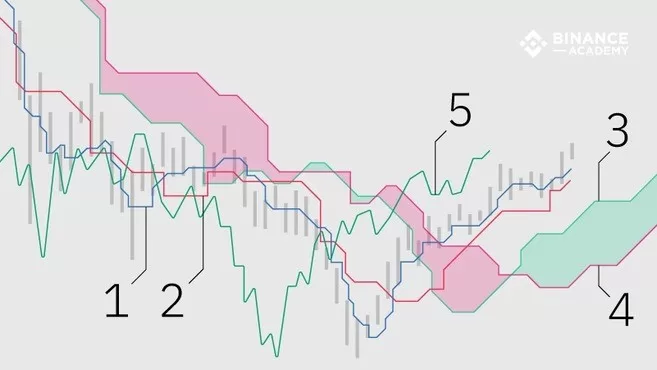

先行带A（3）和先行带B（4）之间的空间称为云带（Kumo），该参数是Ichimoku系统中最值得注意的元素。两条先行带能够预计26日内的市场趋势，因此被视为先行指标。另一方面，迟行带（5）是一个滞后指标，体现了过去26日的趋势。

默认情况下，为方便阅读云带以绿色或红色显示。当先行带A（绿色云线）高于先行带B（红色云线）时，会产生绿色云带。同理，完全相反的情况下会产生红色云带。

[一目均衡图(Ichimoku Cloud)详解](https://www.lgdquant.com/ichimoku-clouds-explained/)